In [1]:
import os
import torch
import pickle
import random
import numpy as np
from autoencoder import *
from sklearn.model_selection import KFold

from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Data loading and preprocessing

In [ ]:
# Create directory (Colab)
!mkdir ./dataset

In [3]:
#%% Define paths

data_root_dir = './dataset'


#%% Create dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

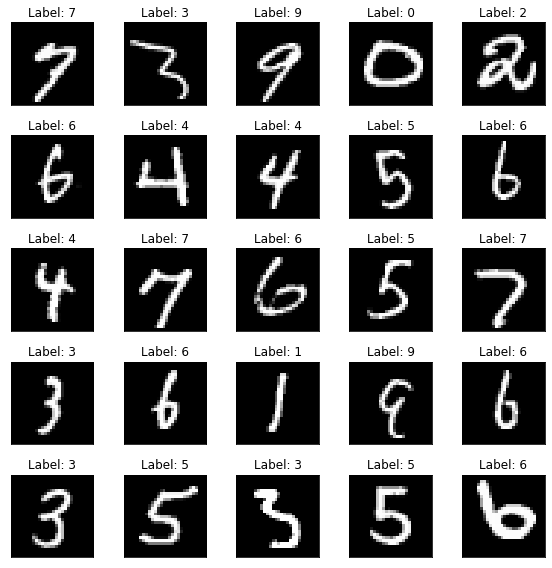

In [4]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Architecture definition

In [5]:
### Initialize the network
net = Autoencoder(encoded_space_dim=encoded_space_dim)

In [6]:
### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 10])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [7]:
#%% Prepare training

### Dimension of the batch
batch_size = 1000
### Number of epochs
num_epochs = 20
### Hidden layer dimension - TODO: tuning
encoded_space_dim = 4

### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define a loss function
loss_fn = torch.nn.MSELoss()

device = torch.device("cpu")
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
print('### ARCHITECTURE ###')
net.to(device)

### ARCHITECTURE ###


Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Con

## Parameter optimization: GridSearch and CrossValidation

In [ ]:
def train_CV(indices, device, encoded_dim=8, lr=1e-3, wd=0, num_epochs=20):

    # K_FOLD parameters
    kf = KFold(n_splits=3, random_state=42, shuffle=True)

    train_loss_log = []
    val_loss_log = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(indices)):
        print("+++ FOLD {} +++".format(fold))

        train_loss_log_fold = []
        val_loss_log_fold = []

        # initialize the net
        cv_net = Autoencoder(encoded_space_dim=encoded_dim)
        
        # Move all the network parameters to the selected device 
        # (if they are already on that device nothing happens)
        cv_net.to(device)

        ### Define a loss function
        loss_fn = torch.nn.MSELoss()

        ### Define an optimizer
        optim = torch.optim.Adam(cv_net.parameters(), lr=lr, weight_decay=wd)

        # create the dataloaders
        train_dataloader_fold = DataLoader(Subset(train_dataset, train_idx), batch_size=500, shuffle=False)
        valid_dataloader_fold = DataLoader(Subset(train_dataset, valid_idx), batch_size=500, shuffle=False)


        for epoch in range(num_epochs):
            print('EPOCH %d/%d' % (epoch + 1, num_epochs))
            ### Training
            avg_train_loss = train_epoch(cv_net, dataloader=train_dataloader_fold, 
                                         loss_fn=loss_fn, optimizer=optim,
                                         device=device) 
            ### Validation
            avg_val_loss = test_epoch(cv_net, dataloader=valid_dataloader_fold, 
                                      loss_fn=loss_fn, optimizer=optim,
                                      device=device) 
            # Print loss
            print('\t TEST - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, avg_train_loss))
            print('\t VALIDATION - EPOCH %d/%d - loss: %f\n' % (epoch + 1, num_epochs, avg_val_loss))

            # Log
            train_loss_log_fold.append(avg_train_loss)
            val_loss_log_fold.append(avg_val_loss)

        train_loss_log.append(train_loss_log_fold)
        val_loss_log.append(val_loss_log_fold)

    return {"train loss": np.mean(train_loss_log, axis=0), 
            "validation loss": np.mean(val_loss_log, axis=0)}

EPOCH 1/20


	 VALIDATION - EPOCH 1/20 - loss: 0.023936




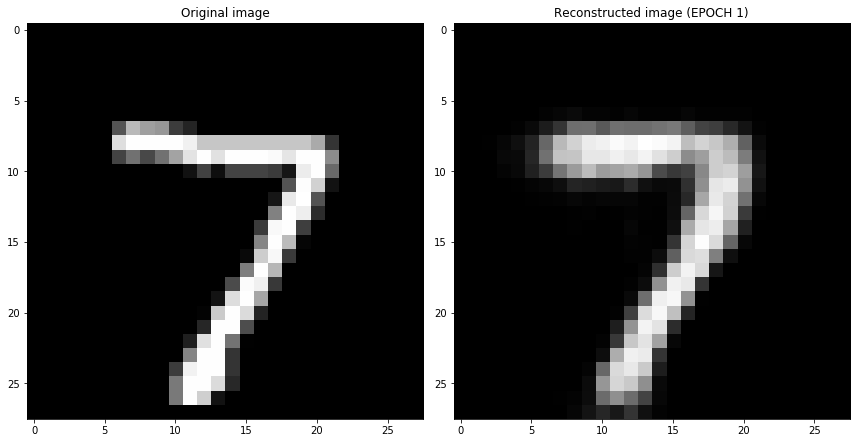

<Figure size 432x288 with 0 Axes>

EPOCH 2/20


	 VALIDATION - EPOCH 2/20 - loss: 0.023046




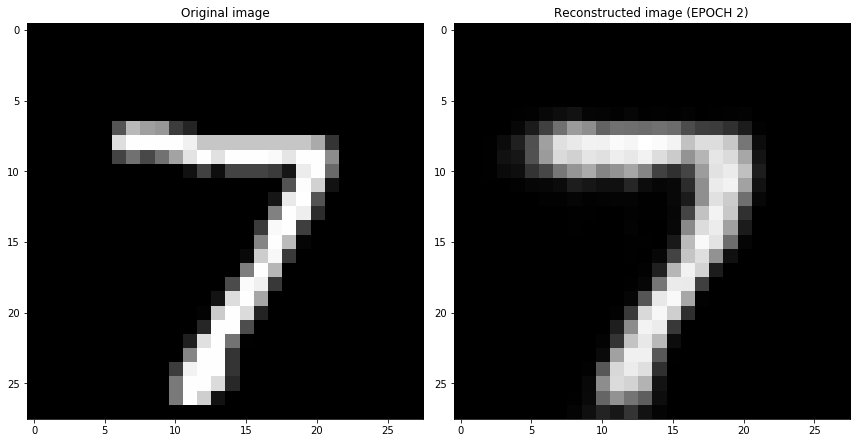

<Figure size 432x288 with 0 Axes>

EPOCH 3/20


	 VALIDATION - EPOCH 3/20 - loss: 0.022147




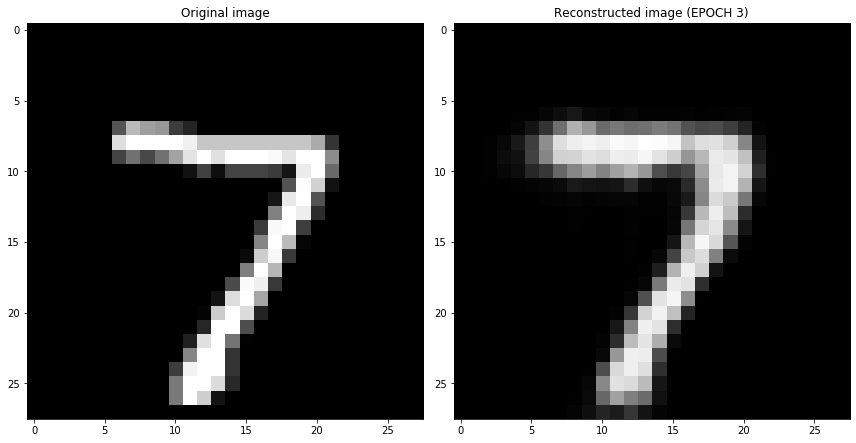

<Figure size 432x288 with 0 Axes>

EPOCH 4/20


	 VALIDATION - EPOCH 4/20 - loss: 0.021605




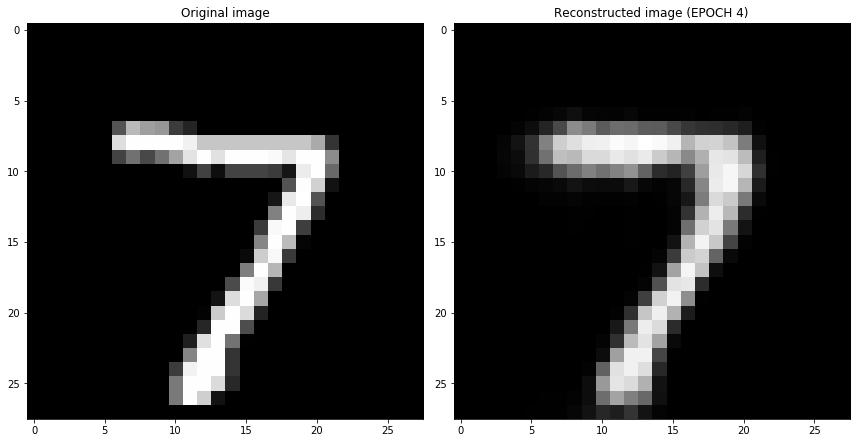

<Figure size 432x288 with 0 Axes>

EPOCH 5/20


	 VALIDATION - EPOCH 5/20 - loss: 0.021078




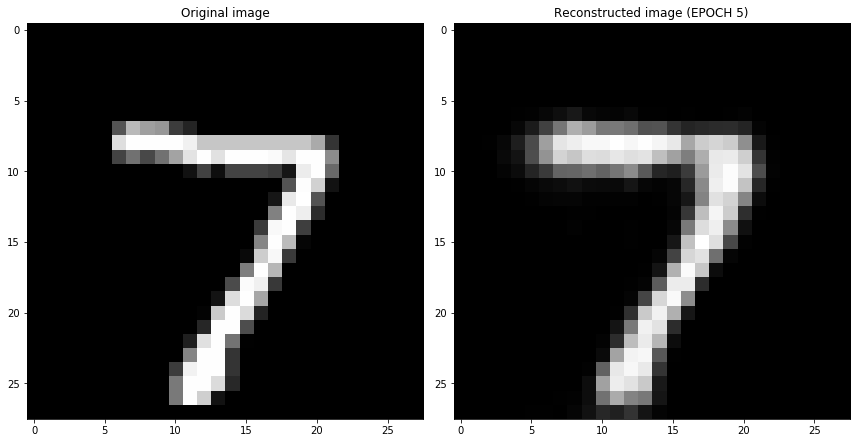

<Figure size 432x288 with 0 Axes>

EPOCH 6/20


	 VALIDATION - EPOCH 6/20 - loss: 0.020741




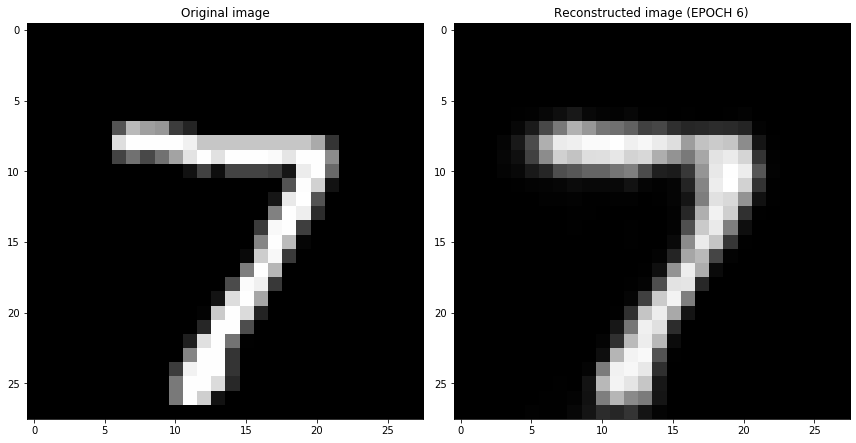

<Figure size 432x288 with 0 Axes>

EPOCH 7/20


	 VALIDATION - EPOCH 7/20 - loss: 0.020321




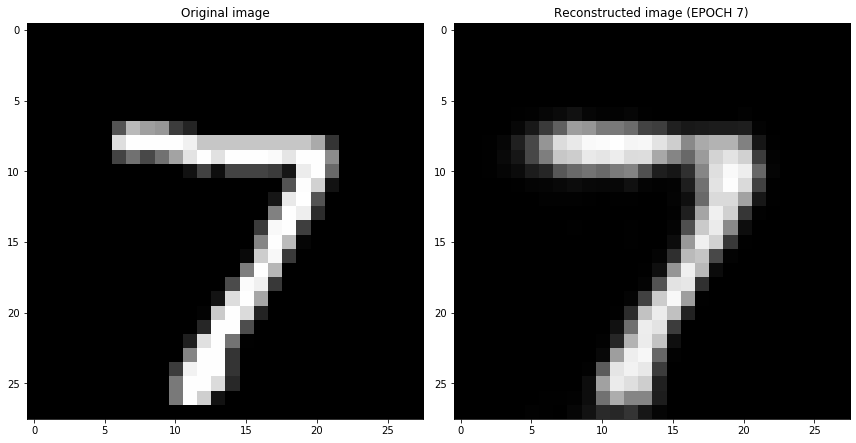

<Figure size 432x288 with 0 Axes>

EPOCH 8/20


	 VALIDATION - EPOCH 8/20 - loss: 0.020037




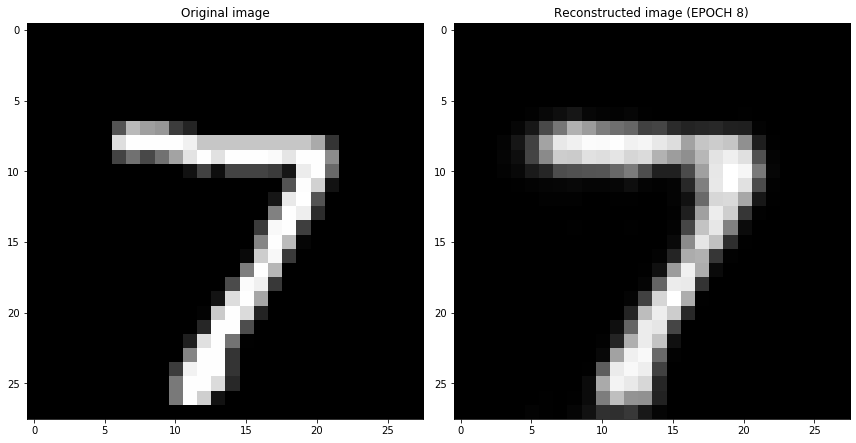

<Figure size 432x288 with 0 Axes>

EPOCH 9/20


	 VALIDATION - EPOCH 9/20 - loss: 0.019825




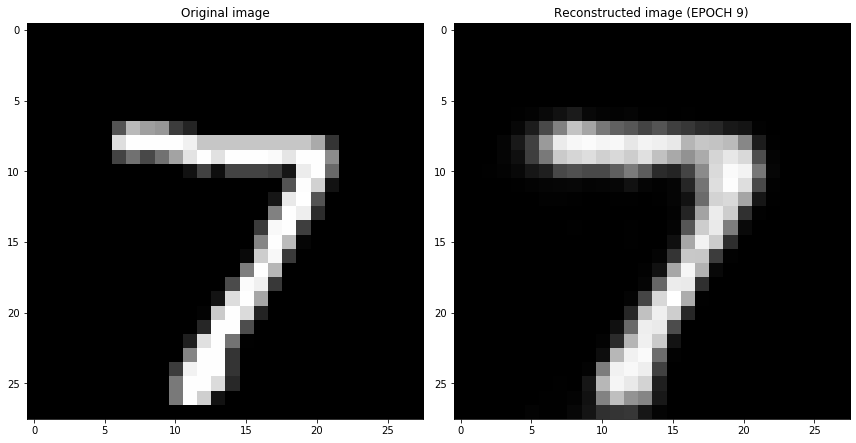

<Figure size 432x288 with 0 Axes>

EPOCH 10/20


	 VALIDATION - EPOCH 10/20 - loss: 0.019580




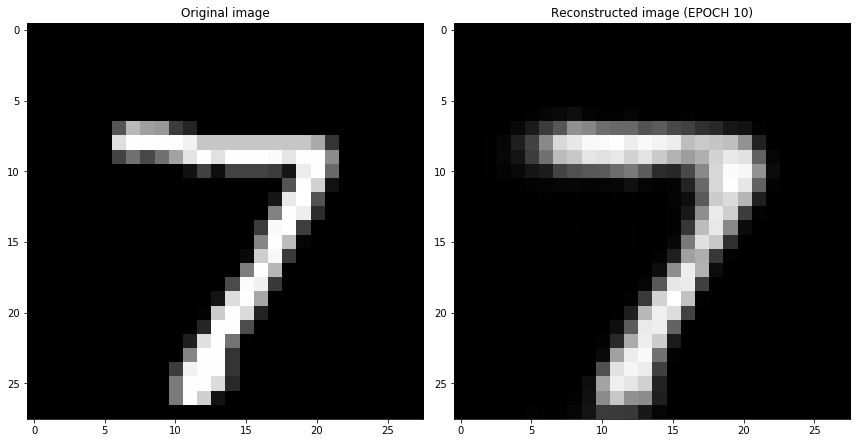

<Figure size 432x288 with 0 Axes>

EPOCH 11/20


	 VALIDATION - EPOCH 11/20 - loss: 0.019242




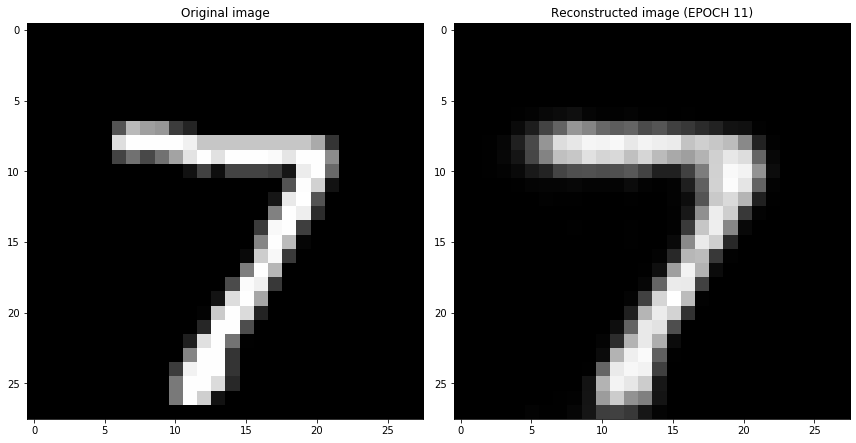

<Figure size 432x288 with 0 Axes>

EPOCH 12/20


	 VALIDATION - EPOCH 12/20 - loss: 0.019065




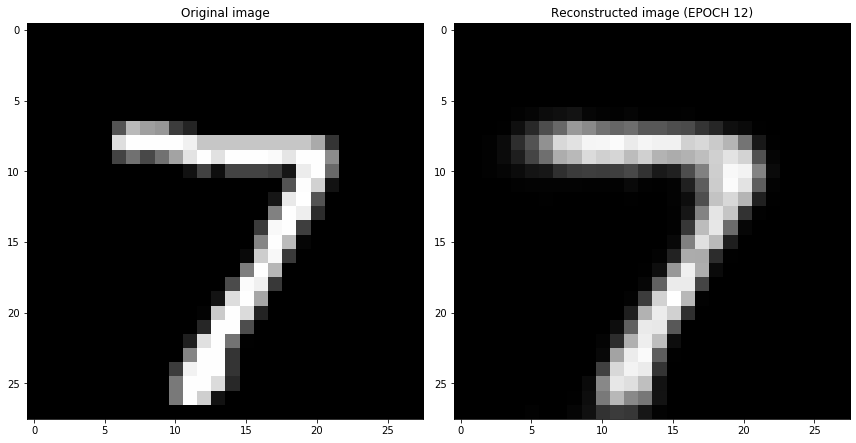

<Figure size 432x288 with 0 Axes>

EPOCH 13/20


	 VALIDATION - EPOCH 13/20 - loss: 0.018836




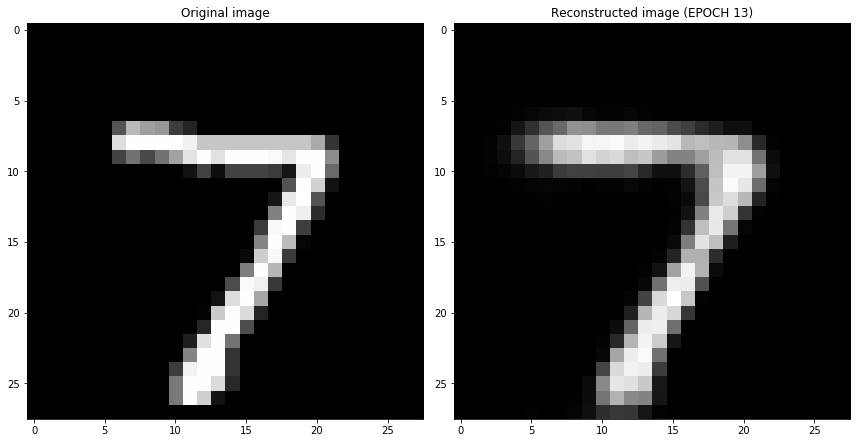

<Figure size 432x288 with 0 Axes>

EPOCH 14/20


	 VALIDATION - EPOCH 14/20 - loss: 0.018640




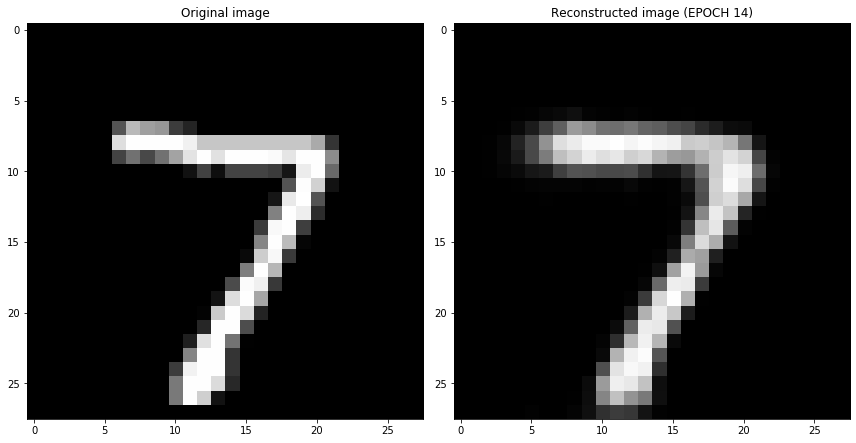

<Figure size 432x288 with 0 Axes>

EPOCH 15/20


	 VALIDATION - EPOCH 15/20 - loss: 0.018574




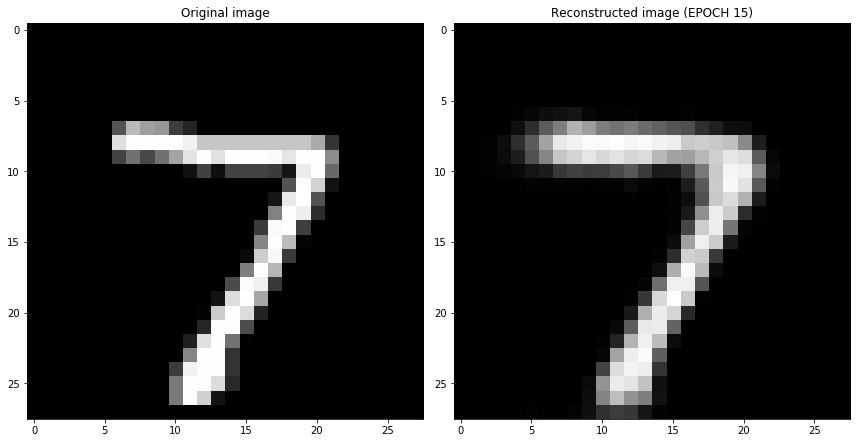

<Figure size 432x288 with 0 Axes>

EPOCH 16/20


	 VALIDATION - EPOCH 16/20 - loss: 0.018238




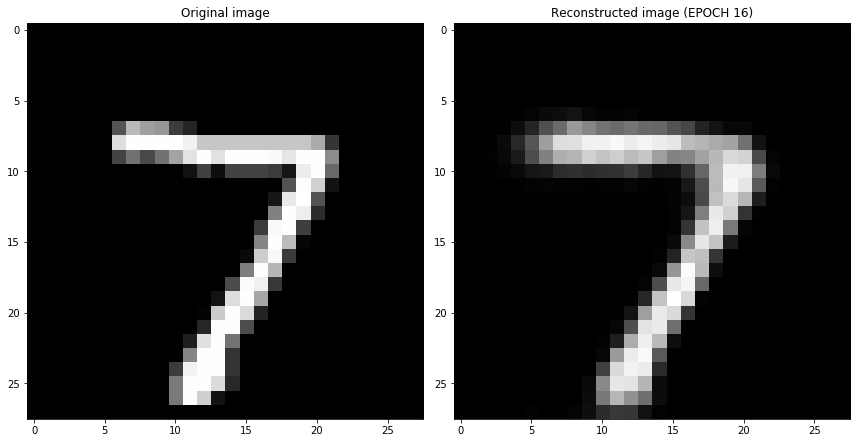

<Figure size 432x288 with 0 Axes>

EPOCH 17/20


	 VALIDATION - EPOCH 17/20 - loss: 0.018190




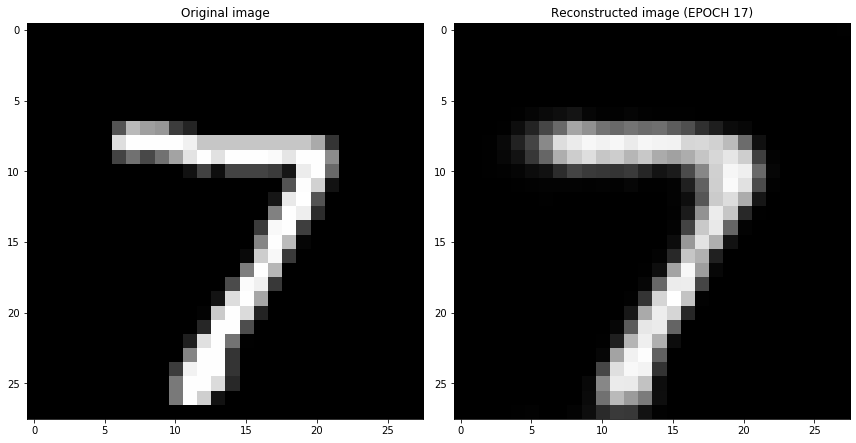

<Figure size 432x288 with 0 Axes>

EPOCH 18/20


	 VALIDATION - EPOCH 18/20 - loss: 0.017905




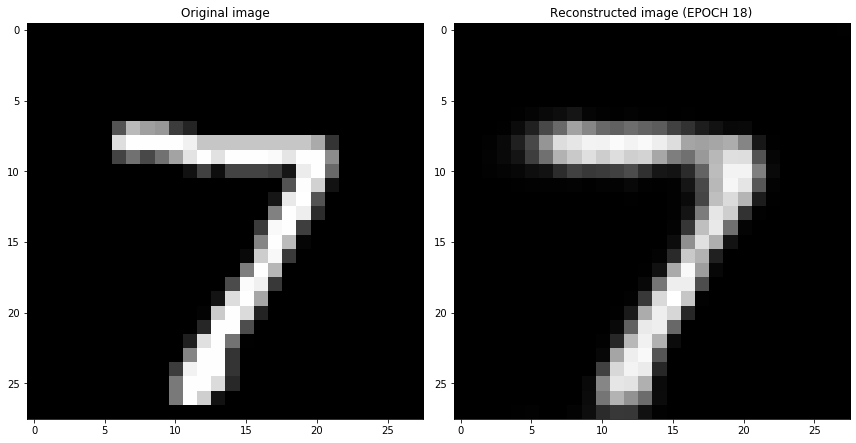

<Figure size 432x288 with 0 Axes>

EPOCH 19/20


	 VALIDATION - EPOCH 19/20 - loss: 0.017969




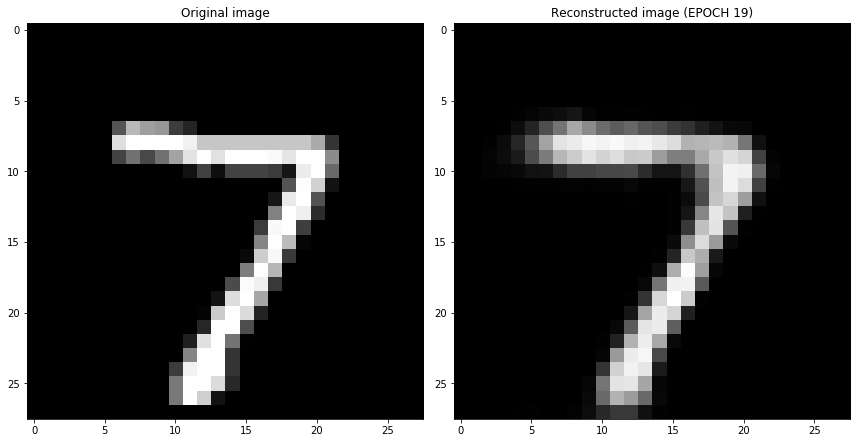

<Figure size 432x288 with 0 Axes>

EPOCH 20/20


	 VALIDATION - EPOCH 20/20 - loss: 0.017753




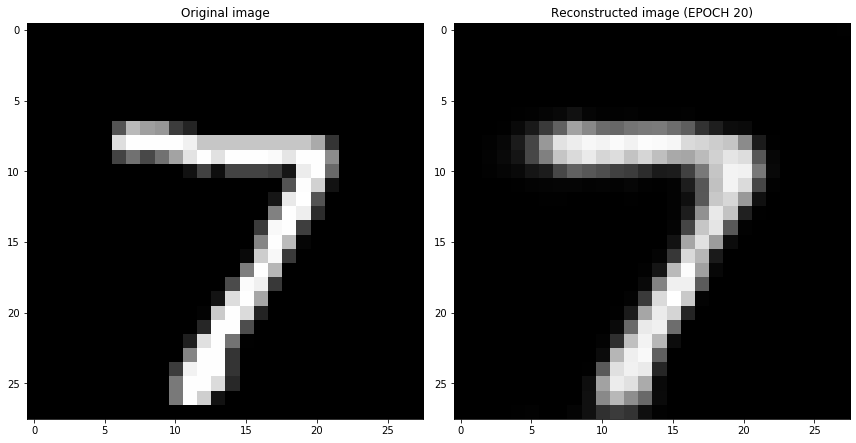

<Figure size 432x288 with 0 Axes>

In [12]:
%%time

results = {}
indices = list(range(len(train_dataset)))

# learning rate cycle
for lr in [1e-2, 1e-3, 1e-4]:
    results[lr] = {}
    # weight decay cycle
    for decay in []:
        print(f'### PARAMETERS: lr = {lr}, decay = {decay} ###')
        results[lr][decay] = train_CV(indices, device, encoded_dim = encoded_space_dim, 
                                      lr = lr, wd = decay, num_epochs = num_epochs)
        
with open(f'CV_loss_{encoded_space_dim}.pickle', 'wb') as f:
    pickle.dump(res, f)

## Training with optimized parameters

In [ ]:
%%time

# Set number of epochs
num_epochs = 100
# TODO: Set parameters
# lr =
# decay = 

train_loss_log = []
val_loss_log = []

### Training cycle
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training
    train_loss = train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim, device=device) 
    print('\n\t TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))
    ### Validation
    val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim, device=device) 
    # Print Validation
    print('\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    img = test_dataset[0][0].unsqueeze(0).to(device)
    net.eval()
    with torch.no_grad():
        rec_img  = net(img)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    plt.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(net.state_dict(), 'net_params.pth')

    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

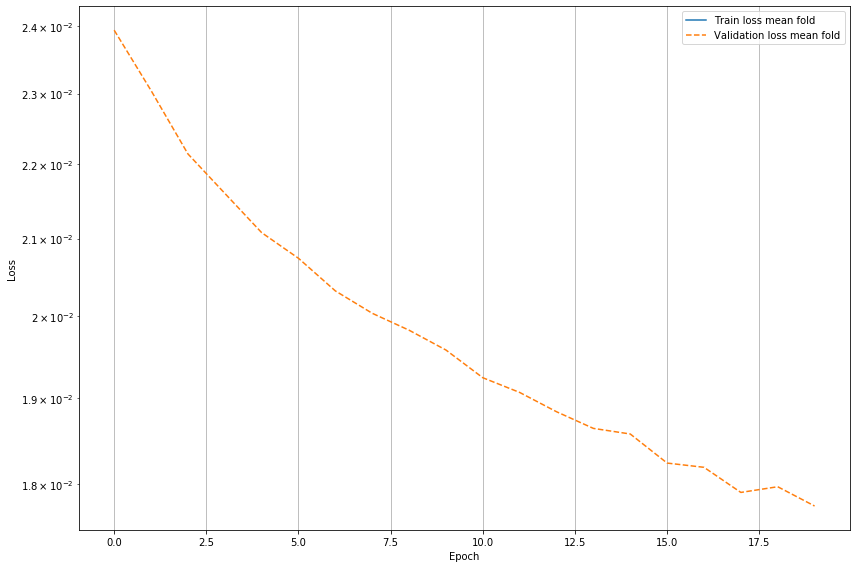

In [13]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_log, 
                label='Train loss mean fold')
plt.semilogy(val_loss_log, 
                label='Validation loss mean fold',
                linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()